Create a jupyter notebook template to do the following - for a given token and date range:
- calculate the hourly return by timestamp
- calculate the hourly volatility (you can use the formula we went over in class)
- calculate maximum drawdown up to that hour for each hour


then plot in a 2x2 grid:
- hourly return
- hourly vol
- maximum drawdown
- close prices
- color each day on the graph

In [106]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
def vol_ohlc(df, lookback=10):
    # compute volatility from df
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [239]:
import scrapbook as sb

def retrieve_data(chosen_token, from_date,to_date):
    # connection to the SQL database at `data.db`
    conn = sqlite3.connect('data.db')
    # create a cursor object from the connection to use for querying:
    cur = conn.cursor()
    cur.execute("SELECT * FROM ohlc WHERE token = (%r) AND ts BETWEEN (%r) AND (%r)"%(chosen_token, from_date,to_date))
    data = cur.fetchall()
    df = pd.DataFrame(
        data,
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD', 'token', 'chain']
    )
    df['hourly_returns(%)'] = (df.close - df.open)/df.open * 100 
    df['volatility'] = vol_ohlc(df)
    df.set_index('ts', inplace=True, drop = True)
    # In case you have a dark jupyter theme
    plt.style.use('dark_background')
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(15,15))
    fig.suptitle('Study of {} from {} to {}'.format(chosen_token, start, ending), fontsize=20)
    df['hourly_returns(%)'].plot(ax=axs[1,0], title = 'Hourly returns', linestyle = 'dotted', rot = 50)
    df['volatility'].plot(ax=axs[1,1], title = 'Hourly volatility', rot = 50)
    df['close'].plot(ax=axs[0,1], title = 'Hourly close price', rot = 50)
    (df.high.cummax() - df.low.cummin()).plot(ax=axs[0,0], title = 'Hourly max drawdown', rot = 50)
    plt.show()

In [231]:
start = '2021-09-01 00:00:00'
ending = '2021-12-01 00:00:00'
token = 'ETH'

C:\Users\campo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


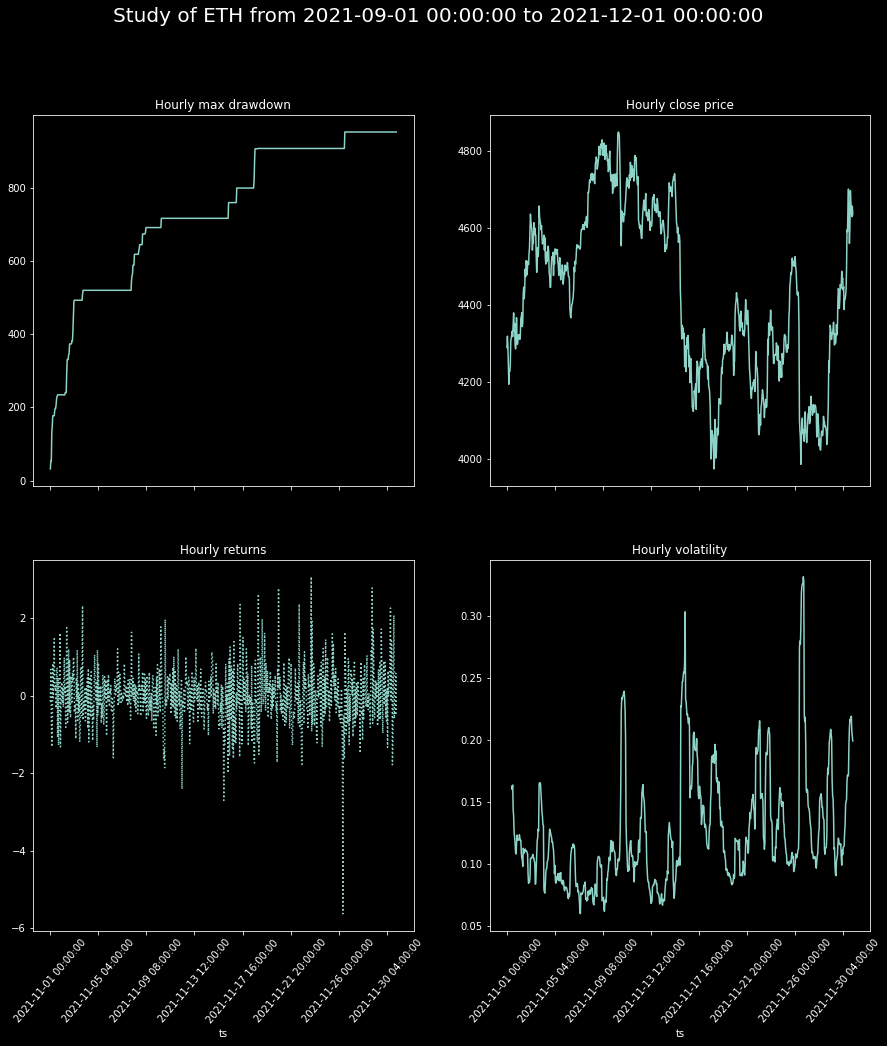

In [240]:
retrieve_data(token,start, ending)